In [1]:
from sklearn import model_selection as cross_validation
from sklearn import cross_validation, datasets, metrics, tree 
from sklearn import ensemble,  learning_curve
import sklearn

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import copy
import re
import math

G:\Main\Programs\Anaconda2x64\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
G:\Main\Programs\Anaconda2x64\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
G:\Main\Programs\Anaconda2x64\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [2]:
PATH = "DM2L_FairTest/"
NAME = "DM2L_"

In [3]:
def loadgtf(s):
    df = pd.read_csv(s, sep = '\t',header=None)
    genes = [df[8][i].split('"')[1] for i,k in enumerate(df[8])]
    df.columns = ['name','source','type','start','end','p1','strand','p2','genes']
    df = df.drop(df[df.type == 'exon'].index)
    return df

def loadfasta(file):
    fin = open(file,'r')
    currkey = ""
    Dres = {}
    L = fin.readlines()
    print len(L)
    for l in L:
        if l[0]=='>':
            currkey = l[1:-1]
            Dres[currkey] = ""
        else:
            Dres[currkey]=Dres[currkey]+l[:-1]
    return Dres

def loadreffasta(file):
    fin = open(file,'r')
    Ref = ""
    L = fin.readlines()
    print len(L)
    wasenterpoint = False
    for l in L:
        if l[0]=='>':
            if wasenterpoint:
                print "No single sequence"
                return
            else:
                wasenterpoint = True
        else:
            Ref=Ref+l[:-1]
    return Ref

def savereads(resf,out):
        f = open(out,'w')
        D_corr = {}
        D_outf = {}
        counter = 0
        for t in resf[:]:
            f.write('>r'+str(counter)+'\n')
            D_corr['r'+str(counter)] = t[0][0]
            D_outf['r'+str(counter)] = t[0][1]
            counter = counter+1
            f.write(t[0][1]+'\n')
        f.close()
        return D_outf

In [4]:
from itertools import product
def joinStrings(stringList):
    return ''.join(string for string in stringList)
def get_all_substrings(input_string, l):
    length = len(input_string)-l
    return [input_string[i:i+l] for i in xrange(length+1)]
def getfeautures(read):
    #print read
    rep = 2
    fs = {joinStrings(s):0 for s in product('ATCG', repeat=rep)}
    
    for sr in get_all_substrings(read,rep):
        if ('N' not in sr and 
        'W' not in sr and
        'Y' not in sr and
        'S' not in sr and
        'M' not in sr and
        'R' not in sr):
            fs[sr] = fs[sr] + 1
    for k in fs:
        fs[k] = fs[k]*1.0/len(read)
    return fs.values()

In [5]:
import re
def getcoords(header):
    T = re.findall(r'\d{1,}\.\.\d{1,}',  header)
    return [(int(t[0]),int(t[1])) for t in [q.split('..') for q in T]]


def getCDS(file):
    return loadfasta(file)


def getClobCoords(CDSdict):
    Res = []
    for k in CDSdict.keys():
        Res = Res+getcoords(k)
    return Res

def getNonCDS(CDSdict, ref):
    NonCDS = {}
    L = list(set(getClobCoords(CDSdict)))
    L.sort()
    
    start = 0
    NonCDScords = []
    for e in L:
        NonCDScords.append((start,e[0]-2))
        start = e[1]
    print len(NonCDScords), len(L)
    for cds in NonCDScords:
        r = ref[cds[0]:cds[1]+1]
        if r!="":
            NonCDS['r:'+str(cds[0])+'-'+str(cds[1]+1)] = r
    return NonCDS

In [6]:
def clean_read(s):
    res = ""
    R = s.split('\n')
    for r in R:
        res = res+r
    return res;

def getrate(clf, read, l= 150):
    l = min(len(read),l)
    frames = [read[k:k+l] for k in range(0,len(read),l)]
    #print frames
    #print frames
    objs = [getfeautures(k) for k in frames]
    #feas = getfeautures(D[R7[4]])
    res = clf.predict(objs)
    #print res
    return sum(res)*1.0/len(res)

class Graph:
    D_str = {}
    D_edge = {}
    D_rate = {}
    def __init__(self, path):
        f = open(path,'r')
        L = []
        D1 = {}
        D_str = {}

        last_node = ""
        for s in f.readlines():
            if s[0]=='>':
                last_node = s[:-2].split(':')[0][1:]
                L.append(s)
                D1[last_node] = 0
                D_str[last_node] = ""
            else:
                D_str[last_node] = D_str[last_node] + s;
                D1[last_node] = D1[last_node]+len(s)-1

        for a in D_str:
            D_str[a] = clean_read(D_str[a])
        D = {}
        vertices = []
        edges = []

        D_edges = {}

        for i,s in enumerate(L):
            s_node = s[:-2].split(':')[0][1:]
            D[s_node] = i
            vertices.append(s_node)
            K = s[:-2].split(':')
            D_edges[s_node] = []
            if (len(K)>1):
                E = s[:-2].split(':')[1].split(',')
                for e in E:
                    D_edges[s_node].append(e)
        
        self.D_str = D_str
        self.D_edges = D_edges
        
    def getmaxedge(self, E,  D, p = True,):
        mx = -1
        es = ""
        if p:
            for e in E:
                if D[e]>mx:
                    mx = D[e]
                    es = e
        else:
            es = self.getmaxedge(E,D)
            mx = D[es]
            for e in E:
                if D[e]<mx:
                    mx = D[e]
                    es = e
        return es

    def extracttracks(self, name, length, D, p = True, S_t = [],   c_len_t = 0):
        S = copy.deepcopy(S_t)
        #print S
        D_str = self.D_str
        c_len = c_len_t
        if S == []:
            S = [[name,D_str[name][:length].upper()]]
        else:
            for i,k in enumerate(S):
                S[i][0] = S[i][0]+'&'+name
                S[i][1] = S[i][1]+D_str[name][:(length-c_len)].upper();

        c_len = len(S[0][1])
        if (c_len == length):
            return S

        Rs = []
        if len(self.D_edges[name])>0:
            ans = self.getmaxedge(self.D_edges[name], D, p)
            Rs2 = self.extracttracks(ans, length, D, p, S,  c_len)
            Rs = Rs+Rs2
        if (Rs == []):
            return [['-','-']]
        return Rs
    
    def countrate(self, clf):
        for d in self.D_str.keys():
            self.D_rate[d]=getrate(clf, self.D_str[d])
    
    def extractreads(self,p, l):
        res = []
        for t in self.D_str.keys():
                res = res+self.extracttracks(t,l,self.D_rate,p)
        res2 = {}
        print len(res)
        count = 0
        for t in res:
            if t[1]!='-':
                #res2['extracted'+str(count)] = t[1]
                res2[t[0]] = t[1]
                count = count+1
        return res2
    def extractnames(self,p, l):
        res = []
        for t in self.D_str.keys():
                res = res+self.extracttracks(t,l,self.D_rate,p)
        res2 = {}
        print len(res)
        count = 0
        for t in res:
            if t[1]!='-':
                res2['extracted'+str(count)] = t[0]
                count = count+1
        return res2

In [7]:
def reverse(r):
    s = ""
    Damins = {'A':'T',
              'T':'A',
              'C':'G',
              'G':'C'}
    for i in range(len(r)-1,-1,-1):
        print i
        s = s+Damins[r[i]]
    return s

def extrcounter(gtf_df, ref):
    D_anno2 = {}
    for g in gtf_df.genes.values:
        D_anno2[g]=gtf_df[gtf_df.genes == g][['name','start','end', 'strand']].values
    D_anno3 = {}
    for k in D_anno2:
        s = ""
        for c in D_anno2[k]:
            s = s+ref[c[1]:c[2]]
        if D_anno2[k][0][3]==-1:
            s = reverse(s)
        D_anno3[k] = s
    return D_anno3

def extrcounter_dataset(gtf_df, fasta_dict):
    D_anno2 = {}
    for g in gtf_df.genes.values:
        D_anno2[g]=gtf_df[gtf_df.genes == g][['name','start','end', 'strand']].values
    D_anno3 = {}
    for k in D_anno2:
        s = ""
        name = D_anno2[k][0][0]
        ref = fasta_dict[name]
        for c in D_anno2[k]:
            s = s+ref[c[1]:c[2]]
        if D_anno2[k][0][3]==-1:
            s = reverse(s)
        D_anno3[k] = s
    return D_anno3

def savefasta(Dfa, name, pref = ""):
    f = open(name,'w')
    fnames = 0
    if pref != "":
        f_names = open(name+'.names','w')
    counter = 0
    for k in Dfa:
        if pref == "":
            f.write('>'+k+'\n')
        else:
            f_names.write(pref+str(counter)+'\t'+k+'\n')
            f.write('>'+pref+str(counter)+'\n')
        f.write(Dfa[k]+'\n')
        counter = counter+1
    f.close()
    if pref != "":
        f_names.close()

        

def loadnames(filenames):
    f = open(filenames,'r')
    Dres = {}
    for k in f.readlines():
        tmp = k.split('\t')
        Dres[tmp[0]]=tmp[1][:-1]
    return Dres
    
def savefirstnames(Dfa, name, pref = ""):
    dR = {}
    counter = 0
    for k in Dfa:
        dR[pref+str(counter)] = k
        counter = counter+1
    return dR

In [8]:
from matplotlib_venn import venn2, venn2_circles, venn3
def merge(frame1, frame2):
    res = pd.concat([frame1, frame2], ignore_index=True)
    return res

def loadblastres(s):
    df = pd.read_csv(s, sep = '\t', header = None)
    #"6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore stitle qcovs
    #df.columns= 'qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore'.split(' ')+'sgi sscinames scomnames sskingdoms stitle qcovs'.split(' ')
    df.columns = "qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore stitle qcovs".split(' ')
    df = df.loc[df.groupby(["qseqid"])["qcovs"].idxmax()]
    return df

def getcrossstats(frame1, frame2, tresh, name1 = "frame1", name2 = "frame2"):
    c1 = 0
    c2 = 0
    t1 = pd.Series(frame1[frame1.qcovs>tresh]['stitle'].values).unique()
    t2 = pd.Series(frame2[frame2.qcovs>tresh]['stitle'].values).unique()
    l1 = len(t1)
    l2 = len(t2)
    for s1 in t1:
        if s1 in t2:
            c1 = c1+1
        else:
            c2 = c2+1
    
    fig = plt.figure()
    print c1, round(c1*100.0/l1), round(c1*100.0/l2,2)
    venn2([set(t1),set(t2)], set_labels = [name1,name2])
    #fig.savefig("venn_"+name1+"_"+name2+"_metrick_NNP.png")
def plot3venn(frame1, frame2, frame3, name1 = 'df1', name2 = 'df2', name3 = 'df3', pref = "", plot = False):
    fig = plt.figure()
    treshhold = 90
    y1 = pd.Series(frame1[(frame1['qcovs']>treshhold)&(frame1['pident']>treshhold)]['stitle'].values).unique()
    y2 = pd.Series(frame2[(frame2['qcovs']>treshhold)&(frame2['pident']>treshhold)]['stitle'].values).unique()
    y3 = pd.Series(frame3[(frame3['qcovs']>treshhold)&(frame3['pident']>treshhold)]['stitle'].values).unique()
   # y1t = [getname(t) for t in y1]
    #y2t = [getname(t) for t in y2]
   # y3t = [getname(t) for t in y3]
    #res = (set(y1t).difference(set(y2t))).intersection(set(y3t))
    
    venn3([set(y1), set(y2), set(y3)], set_labels=[name1,name2,name3])
    if plot:
        fig.savefig(pref+name1+name2+name3+".png")


In [9]:
def getprotset(frame1,treshhold = 90):
    y1 = pd.Series(frame1[(frame1['qcovs']>treshhold)&(frame1['pident']>treshhold)]['stitle'].values).unique()
    return set(y1)

In [10]:
def getcuttedsequence(inp, outp,length, step, prefix = ""):
    r = loadreffasta(inp)
    fout = open(outp,'w')
    for i in range(0,len(r)-length,step):
        fout.write('>'+prefix+':'+str(i)+'\n')
        fout.write(r[i:i+length]+'\n')
    fout.close()

In [11]:
DM2L_graph = Graph(PATH+NAME+'graph.fastg')

In [12]:
DM2L_linearCDS = extrcounter_dataset(loadgtf(PATH+NAME+'linear.gtf'),{"NT_033779.5 Drosophila melanogaster chromosome 2L":loadreffasta(PATH+NAME+'linear.fasta')})

335913


In [13]:
DM2L_graphCDS = extrcounter_dataset(loadgtf(PATH+NAME+'graph.gtf'),loadfasta(PATH+NAME+'graph.fastg'))

872146


In [14]:
DM2L_contigsCDS = extrcounter_dataset(loadgtf(PATH+NAME+'contigs.gtf'),loadfasta(PATH+NAME+'contigs.fasta'))

420802


In [15]:
DM2L_graphCDSnames = savefirstnames(DM2L_graphCDS, PATH+NAME+"graph_CDS.fa", "graphCDS")
DM2L_linearCDSnames = savefirstnames(DM2L_linearCDS, PATH+NAME+"linear_CDS.fa", "linearCDS")
DM2L_contigsCDSnames = savefirstnames(DM2L_contigsCDS, PATH+NAME+"contigs_CDS.fa","contigsCDS")

In [16]:
DM2L_tracksCDS = extrcounter_dataset(loadgtf(PATH+NAME+'graph_tracks.gtf'),loadfasta(PATH+NAME+'graph_tracks.fa'))
DM2L_contigsCDSnames = savefirstnames(DM2L_tracksCDS, PATH+NAME+"contigs_CDS.fa","contigsCDS")

54294


In [17]:
DM2L_graph.D_str.values()[:10]

['CTTTTGCGAACGCTTCAAACGCACCTGCCGACCCACCGATTGGTATCCGGTTGAGTTGGAGCATCGCCAGCAGTACGAGGAAGCTGTTAGCAATACGGATATGACCCAACA',
 'GTTCACTCGCTTTGTTGCTGTGCGATGGTGAGTAGTGTGTATGGTGTATCTTGTATCTGTAGCTGCGTCTGTGCATAATGTATCTCC',
 'TTTTTTTAACTTGTATGTTGTTTTAACCGTTTTTTTCTTTTTAATTTGTATGTTGTTTTA',
 'TTTTTTAAAAGCGAAATATTTTTTTTAAACACTTTTAATGTTAATGTTACATCATTT',
 'GTCATTAGAGTATTCATCTTGCGGCGTGTGAAAAATTAATAAGGCAATGATTGTTAAGTGCTTGTGTCCGCACTTCG',
 'TGGTTGCGATGGGGCCACCTCACTAACTGAAGTGGGTTCCGGTTGTGTCTCGGGCGTTACTTCTTCTACGACTGTAGTCACCTCA',
 'ATTGTTGATAATTTTGTCGGGGTGCGGCGAACGGTGCATTACCGAAATTGAGCATG',
 'ATTCCATTTCCTCAAGCGGCCTGCCTCACTTGGCAAATGCAATTCACTGCAATTCAGTGCAATTCTGTGCCAGATTCATTCGTTTTAACATCACAGCATCTCACGTGCCACA',
 'GAGCATACGTGTGCACACATACAGCTGTCTGCTATCACTGTATGCGTAGAAAAGACCTGTTCGCTGTAGCGCTCTCCGCT',
 'TTTACATGATTTAACACTCAGCGAGCCACAAATGATAAATGAAATATACATATAATCGGGCATTGCTCAAATACACAAATTCAAATATGCGTGCCATAATAGTTTGGTTACTTTTCATTTTCTAACATTTTCCAGCATTTTCCCACATATTTTGCATTACATTACATCGTGCAGCTTGCTTCACAACTTAAACGGAAAGGTGTTTCTGATTCGAAAGTGGTAATCGTT

In [18]:
DM2L_chrom = loadreffasta(PATH+NAME+'linear.fasta')
DM2L_refCDS = getCDS(PATH+NAME+'refCDS.fasta')
DM2L_refNonCDS = getNonCDS(DM2L_refCDS, DM2L_chrom)
X = [getfeautures(r) for r in DM2L_refCDS.values()]
X_neg = [getfeautures(r) for r in DM2L_refNonCDS.values()]
print "datasets length:", len(X),len(X_neg)
k = 4000
X_train = X[:k]+X_neg[:k]
X_test = X[k:2*k]+X_neg[k:2*k]
y_train = [1]*len(X[:k])+[0]*len(X_neg[:k])
y_test = [1]*len(X[k:2*k])+[0]*len(X_neg[k:2*k])
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support as ttest
clf = ensemble.RandomForestClassifier(n_estimators = 25, max_depth = 4, random_state = 1)
cross_val_score(clf, X_train,y_train, cv = 20).mean()
clf.fit(X_train,y_train)

335913
172368
11111 11111
datasets length: 5684 10344


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [19]:
DM2L_graph.countrate(clf)

In [20]:
DM2L_track_names = DM2L_graph.extractnames(True, 5000)
DM2L_graph_tracks = DM2L_graph.extractreads(True, 5000)
savefasta(DM2L_graph_tracks, PATH+NAME+"graph_tracks.fa", "graph_tracks")
DM2L_graph_tracks_names = savefirstnames(DM2L_graph_tracks, PATH+NAME+"graph_tracks.fa", "graph_tracks")

49748
49748


In [21]:
DM2L_graph_tracksCDS = extrcounter_dataset(loadgtf(PATH+NAME+"graph_tracks.gtf"),loadfasta(PATH+NAME+"graph_tracks.fa"))

54294


In [22]:
savefasta(DM2L_graph_tracksCDS, PATH+NAME+"graph_tracksCDS.fa", "graph_tracksCDS")
DM2L_graph_tracksCDS_names = savefirstnames(DM2L_graph_tracksCDS, PATH+NAME+"graph_tracksCDS.fa", "graph_tracksCDS")

In [23]:
prot_linear = loadblastres(PATH+NAME+"linear_CDS.fa.blt")
prot_ref = loadblastres(PATH+NAME+"ref_CDS.fa.blt")
prot_graph = loadblastres(PATH+NAME+"graph_CDS.fa.blt")
prot_contigs = loadblastres(PATH+NAME+"contigs_CDS.fa.blt")
prot_tracks = loadblastres(PATH+NAME+"graph_tracksCDS.fa.blt")
prot_graph_ex = merge(prot_graph,prot_tracks)
prot_grapg_mixed = merge(prot_graph_ex,prot_contigs)

In [24]:
PREF = 'final'

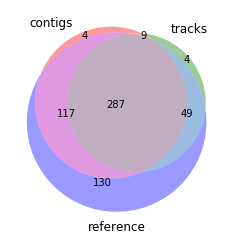

In [25]:
plot3venn(prot_contigs,prot_tracks,prot_ref,'contigs','tracks','reference', PATH+PREF, False)

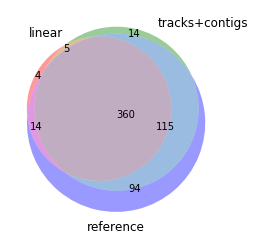

In [26]:
plot3venn(prot_linear,prot_grapg_mixed,prot_ref,'linear','tracks+contigs','reference', PATH+PREF, True)

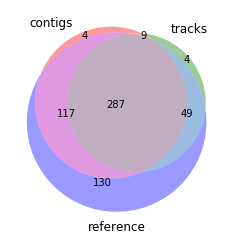

In [27]:
plot3venn(prot_contigs,prot_tracks,prot_ref,'contigs','tracks','reference', PATH+PREF)

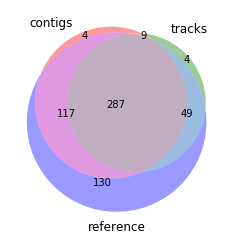

In [28]:
plot3venn(prot_contigs,prot_tracks,prot_ref,'contigs','tracks','reference', PATH+PREF)

In [29]:
prot_linear.head()

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,stitle,qcovs
0,linearCDS0,gi|75037838|sp|Q4TTV7.1|GPL_GLOAU,43.23,266,129,10,769,5,20,274,9.000000e-57,189.0,RecName: Full=Lectizyme; AltName: Full=Proteol...,91
1416,linearCDS10,gi|85701303|sp|P07713.2|DECA_DROME,100.00,280,0,0,1491,2330,309,588,0.000000e+00,538.0,RecName: Full=Protein decapentaplegic; Short=P...,74
14569,linearCDS100,gi|550544315|sp|Q61789.4|LAMA3_MOUSE,33.08,402,212,10,744,1811,148,538,8.000000e-65,217.0,RecName: Full=Laminin subunit alpha-3; AltName...,87
248249,linearCDS1000,gi|1353154|sp|Q09575.1|YRD6_CAEEL,23.57,157,100,6,2396,2866,489,625,1.100000e+00,37.4,RecName: Full=Uncharacterized protein K02A2.6,14
248264,linearCDS1001,gi|94730363|sp|O02350.3|CBPA1_ANOGA,50.26,189,93,1,682,1248,237,424,2.000000e-54,192.0,RecName: Full=Zinc carboxypeptidase A 1; AltNa...,94


In [30]:
prot_linear_cutted = loadblastres(PATH+NAME+"linear_cuttedCDS.blt")

In [31]:
def getsector(pp1,pp2,pp3): #returns proteins
    return list((getprotset(pp1).difference(getprotset(pp2))).intersection(getprotset(pp3)))

def originnames(bltfile, listprots, tresh = 90): #returns name of seq
    R ={}
    for l in listprots:
        tk = bltfile[(bltfile['stitle'] == l)&(bltfile['qcovs']>tresh)&(bltfile['pident']>tresh)]["qseqid"].values
        R[l]=[]
        for k in tk:
            R[l].append(k)
    return R
def originseqs(CDSnames, NamesDict, gtf_db):
    q = []
    for k in CDSnames:
        q.append(NamesDict[k])
    return gtf_db[gtf_db['genes'].isin(q)]


def transname(s):
    if ':' in s:
        return s.split(':')[0]
    else:
        return s[:-1]


def origgtf(pp1,pp2,pp3,gtf,NamesDict):
    listprots = getsector(pp1,pp2,pp3)
    print len(listprots), listprots[0]
    tmp = originnames(pp1,listprots)
    tmp2 = originseqs(tmp,NamesDict,gtf)
    return tmp

def gettranscr(CDSnames, NamesDict, gtf_db):
    q = []
    for k in CDSnames:
        q.append(NamesDict[k])
    return gtf_db[gtf_db['genes'].isin(q)]

def extractgenestartend(gtf_df, names):
    D_anno2 = {}
    for g in gtf_df.genes.values:
        D_anno2[g]=gtf_df[gtf_df.genes == g][['name','start','end', 'strand']].values
       
    D_anno3 = {}
    for g in D_anno2:
        n = D_anno2[g][0][0]
        D_anno3[names[n]] = getrange(D_anno2[g])
    return D_anno3

def getrange(part):
    mn = min(part[0][1],part[0][2])
    mx = min(part[0][1],part[0][2])
    for p in part:
        for i in range(1,3):
            if p[i]>mx:
                mx = p[i]
            if p[i]<mn:
                mn = p[i]
    return (mn,mx)


def branchparser(s,GR):
    s1 = s.split('&')
    #print s1
    res = [0]
    for s2 in s1:
        res.append(res[-1]+len(GR.D_str[s2]))
    return res

def isbranch(s,coords,GR):
    s1 = branchparser(s,GR)
    for tmp1 in s1:
        if (tmp1<coords[1]) and (tmp1>coords[0]):
            return True
    return False

In [32]:
NewTracksGtf = loadgtf(PATH+NAME+'graph_tracks.gtf')

In [33]:
newProts = getsector(prot_tracks,prot_contigs,prot_ref)
print len(newProts), newProts[0]

49 RecName: Full=Centaurin-gamma-1A


In [34]:
newCDS = originnames(prot_tracks,newProts)
k = newCDS.keys()[1]
print k, newCDS[k]

RecName: Full=Galactosylgalactosylxylosylprotein 3-beta-glucuronosyltransferase S; AltName: Full=Beta-1,3-glucuronyltransferase S; AltName: Full=Glucuronosyltransferase S; Short=GlcAT-S; AltName: Full=UDP-glucuronosyltransferase S; Short=DmGlcAT-BSI ['graph_tracksCDS10424', 'graph_tracksCDS12320', 'graph_tracksCDS13358', 'graph_tracksCDS5593', 'graph_tracksCDS5763']


In [35]:
df1 = []
for k in newCDS:
    for n in [originseqs(newCDS[k],DM2L_graph_tracksCDS_names,NewTracksGtf)['name'].values[0]]:
        df1.append(n)

In [36]:
len(set(df1))

48

In [37]:
outex = loadfasta(PATH+NAME+"graph_tracks.fa")

54294


In [63]:
f = open(PATH+NAME+"RNAtracks.fa",'w')
for k in set(df1):
    f.write('>'+k+'\n')
    f.write(outex[k]+'\n')
f.close()
    

In [37]:
newCDS2 = {}
for k in newCDS:
    tmp1 = originseqs(newCDS[k],DM2L_graph_tracksCDS_names,NewTracksGtf)
    tmp2 = extractgenestartend(tmp1,DM2L_graph_tracks_names)
    newCDS2[k]=tmp2

In [38]:
k=newCDS2.keys()[0]
print k, newCDS2[k]

RecName: Full=Centaurin-gamma-1A {"EDGE_11588_length_117_cov_2.70968'&EDGE_8907_length_34643_cov_5.4725'": (2700L, 4977L), "EDGE_17198_length_72_cov_26.9412'&EDGE_2021_length_56_cov_80'&EDGE_4531_length_93_cov_130.079'&EDGE_22313_length_161_cov_145.123'&EDGE_6724_length_206_cov_148.536'&EDGE_23850_length_232_cov_39.1073'&EDGE_4760_length_1881_cov_158.22'&EDGE_21586_length_111_cov_26.3214'&EDGE_21585_length_139_cov_39.0119&EDGE_4755_length_65_cov_152.6&EDGE_10361_length_87_cov_36.0312'&EDGE_10359_length_121_cov_16.9242&EDGE_888_length_56_cov_157'&EDGE_16144_length_88_cov_126.818'&EDGE_16145_length_78_cov_2.91304&EDGE_8250_length_131_cov_3.38158&EDGE_12960_length_66_cov_125.273&EDGE_17217_length_88_cov_113.848&EDGE_3342_length_468_cov_160.329'&EDGE_20437_length_111_cov_138.107'&EDGE_20438_length_260_cov_175.283&EDGE_12586_length_63_cov_155.625&EDGE_10141_length_265_cov_139.348'&EDGE_10140_length_400_cov_191.504": (2610L, 4953L), 'EDGE_21773_length_13467_cov_5.61281': (2707L, 4984L)}


In [186]:
newCDS3 = {}
for k in newCDS2:
    newCDS3[k]=[]
    for q in newCDS2[k]:
        newCDS3[k].append(isbranch(q,newCDS2[k][q],DM2L_graph))

In [191]:
count = 0
for k in newCDS3:
    if False in newCDS3[k]:
        count = count+1
print count-len(newCDS3)

-20


In [182]:
newCDS2.values()[0]

{"EDGE_11588_length_117_cov_2.70968'&EDGE_8907_length_34643_cov_5.4725'": (2700L,
  4977L),
 "EDGE_17198_length_72_cov_26.9412'&EDGE_2021_length_56_cov_80'&EDGE_4531_length_93_cov_130.079'&EDGE_22313_length_161_cov_145.123'&EDGE_6724_length_206_cov_148.536'&EDGE_23850_length_232_cov_39.1073'&EDGE_4760_length_1881_cov_158.22'&EDGE_21586_length_111_cov_26.3214'&EDGE_21585_length_139_cov_39.0119&EDGE_4755_length_65_cov_152.6&EDGE_10361_length_87_cov_36.0312'&EDGE_10359_length_121_cov_16.9242&EDGE_888_length_56_cov_157'&EDGE_16144_length_88_cov_126.818'&EDGE_16145_length_78_cov_2.91304&EDGE_8250_length_131_cov_3.38158&EDGE_12960_length_66_cov_125.273&EDGE_17217_length_88_cov_113.848&EDGE_3342_length_468_cov_160.329'&EDGE_20437_length_111_cov_138.107'&EDGE_20438_length_260_cov_175.283&EDGE_12586_length_63_cov_155.625&EDGE_10141_length_265_cov_139.348'&EDGE_10140_length_400_cov_191.504": (2610L,
  4953L),
 'EDGE_21773_length_13467_cov_5.61281': (2707L, 4984L)}

In [165]:
L = []
for t in extractgenestartend(df1,"").keys():
    L.append(set(DM2L_graph_tracks_names[t].split('&')))

In [172]:
for i in range(0,4):
    print L[i].intersection(L[i+1])

set([])
set([])
set([])
set([])


In [111]:
NewTracks = origgtf(prot_tracks,prot_contigs,prot_ref,loadgtf(PATH+NAME+'graph_tracks.gtf'),DM2L_graph_tracksCDS_names)))

49 RecName: Full=Centaurin-gamma-1A


In [150]:
gettranscr(newCDS[k], DM2L_graph_tracksCDS_names, NewTracksGtf)

,name,source,type,start,end,p1,strand,p2,genes
2212,graph_tracks18818,GeneMark.hmm,CDS,2610,2751,.,+,0,"gene_id ""313_g""; transcript_id ""313_t"";"
2214,graph_tracks18818,GeneMark.hmm,CDS,2845,2979,.,+,2,"gene_id ""313_g""; transcript_id ""313_t"";"
2216,graph_tracks18818,GeneMark.hmm,CDS,3047,4330,.,+,2,"gene_id ""313_g""; transcript_id ""313_t"";"
2218,graph_tracks18818,GeneMark.hmm,CDS,4397,4514,.,+,2,"gene_id ""313_g""; transcript_id ""313_t"";"
2220,graph_tracks18818,GeneMark.hmm,CDS,4578,4953,.,+,1,"gene_id ""313_g""; transcript_id ""313_t"";"
66153,graph_tracks8613,GeneMark.hmm,CDS,2700,2841,.,+,0,"gene_id ""9526_g""; transcript_id ""9526_t"";"
66155,graph_tracks8613,GeneMark.hmm,CDS,2935,3069,.,+,2,"gene_id ""9526_g""; transcript_id ""9526_t"";"
66157,graph_tracks8613,GeneMark.hmm,CDS,3137,4420,.,+,2,"gene_id ""9526_g""; transcript_id ""9526_t"";"
66159,graph_tracks8613,GeneMark.hmm,CDS,4487,4604,.,+,2,"gene_id ""9526_g""; transcript_id ""9526_t"";"
66161,graph_tracks8613,GeneMark.hmm,CDS,4668,4977,.,+,1,"gene_id ""9526_g""; transcript_id ""9526_t"";"


In [72]:
k = DM2L_graph_tracksCDS_names.keys()[0]
print k, DM2L_graph_tracksCDS_names[k]

graph_tracksCDS10926 gene_id "11318_g"; transcript_id "11318_t";


In [74]:
T = gettranscr(NewTracks, DM2L_graph_tracksCDS_names, NewTracksGtf)

In [75]:
T2 = extractgenestartend(T,"")
print len(T2), T2.keys()[2], T2[T2.keys()[2]]

In [123]:
T.head(9)

,name,source,type,start,end,p1,strand,p2,genes
25,graph_tracks1683,GeneMark.hmm,stop_codon,2949,2951,.,-,0,"gene_id ""6_g""; transcript_id ""6_t"";"
26,graph_tracks1683,GeneMark.hmm,CDS,2949,3717,.,-,1,"gene_id ""6_g""; transcript_id ""6_t"";"
28,graph_tracks1683,GeneMark.hmm,CDS,3773,3965,.,-,2,"gene_id ""6_g""; transcript_id ""6_t"";"
30,graph_tracks1683,GeneMark.hmm,CDS,4024,4119,.,-,2,"gene_id ""6_g""; transcript_id ""6_t"";"
340,graph_tracks26333,GeneMark.hmm,stop_codon,1111,1113,.,-,0,"gene_id ""46_g""; transcript_id ""46_t"";"
341,graph_tracks26333,GeneMark.hmm,CDS,1111,1410,.,-,0,"gene_id ""46_g""; transcript_id ""46_t"";"
343,graph_tracks26333,GeneMark.hmm,CDS,1472,1576,.,-,0,"gene_id ""46_g""; transcript_id ""46_t"";"
344,graph_tracks26333,GeneMark.hmm,start_codon,1574,1576,.,-,0,"gene_id ""46_g""; transcript_id ""46_t"";"
350,graph_tracks26333,GeneMark.hmm,start_codon,4572,4574,.,+,0,"gene_id ""48_g""; transcript_id ""48_t"";"


In [76]:
DM2L_graph_tracks_names['graph_tracks25504']

"EDGE_16622_length_111_cov_6.44643&EDGE_3009_length_23686_cov_8.0289'"

In [77]:
branchparser("EDGE_18186_length_126_cov_5.78873'&EDGE_18185_length_11977_cov_7.19334", DM2L_graph)

[0, 126, 12103]

In [78]:
K = extractgenestartend(NewTracksGtf,"")

In [127]:
c = 0
res = []
for k in T2:
    qname = DM2L_graph_tracks_names[k]
    a = branchparser(qname,DM2L_graph)
    for tmp1 in a:
        if (tmp1<T2[k][1]) and (tmp1>T2[k][0]):
            if (qname,T2[k], a) not in res:
                res.append((qname,T2[k], a))

In [131]:
for k in res[0][0].split('&'):
    print len(DM2L_graph.D_edges[k])

1
1
2
1
1
2
2
2
1
1
1
2
1
1
2
1
1
1
1
1
1
2
2
1
1
1
2
1
2
1
1
2
1
1
1
1
2
1
1
1
1
1
1
2
1
1
1
2
1
1
2
1
2
1
1
1
2
1
1
1
2
1
1
2
1
2
1
1
1


In [44]:
q = K.keys()[0]
print getrange(K[q])
print DM2L_graph_tracks_names[q]

NameError: name 'K' is not defined

In [250]:
len(loadfasta(PATH+NAME+'contigs.fasta'))

420802


18212

In [101]:
NewTracksEdges = []
for t in NewTracks:
    for k in DM2L_graph_tracks_names[t].split('&'):
        NewTracksEdges.append(k)

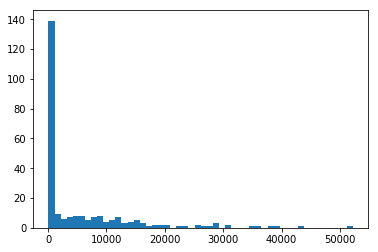

In [102]:
fig = plt.figure()
H = [len(DM2L_graph.D_str[k]) for k in NewTracksEdges]
a =plt.hist(H,bins = len(H)/5)
fig.savefig("LengthNewTracks.png")

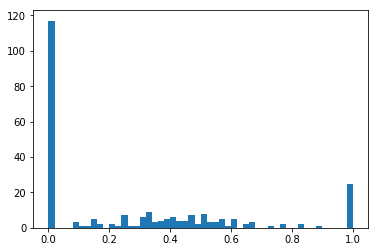

In [103]:
fig = plt.figure()
examp = [DM2L_graph.D_str[k] for k in NewTracksEdges]
subjs = [getfeautures(r) for r in examp]
answs = [getrate(clf,s) for s in examp]
a = plt.hist(answs, bins = len(answs)/5)
fig.savefig("ClfNewTracks.png")

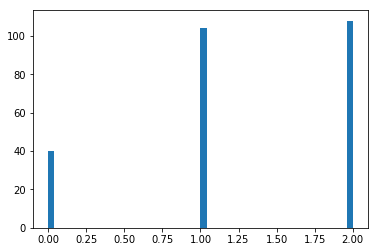

In [104]:
fig = plt.figure()
H = [len(DM2L_graph.D_edges[k]) for k in NewTracksEdges]
a =plt.hist(H,bins = len(H)/5)
fig.savefig("EdgesNewTracks.png")

54126


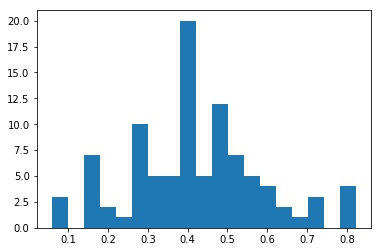

In [158]:
f = loadfasta(PATH+"DM2L_graph_tracks.fa")
r = []
for k in NewTracks:
    r.append(getrate(clf,f[k]))
fig = plt.figure()
a =plt.hist(r,bins = len(r)/5)
fig.savefig("ClfTotalTracks.png")

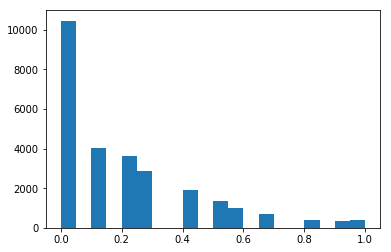

In [113]:
r = [getrate(clf,s) for s in f.values()]
fig = plt.figure()
a =plt.hist(r,20)
fig.savefig("ClfAllOfTracks.png")

In [114]:
len(r)

27063

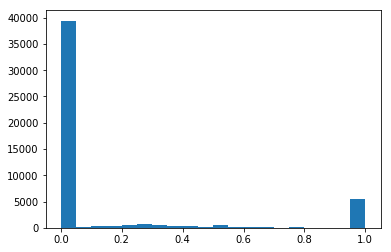

In [115]:
r = [getrate(clf,s) for s in DM2L_graph.D_str.values()]
fig = plt.figure()

fig.savefig("ClfAllOfGraph.png")

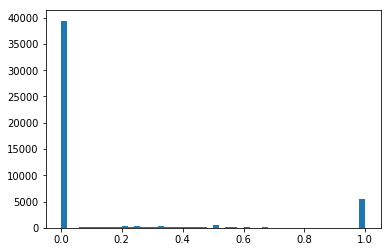

In [116]:
a =plt.hist(r,50)

In [168]:
r = []
r2 = []
for node in NewTracksEdges:
   # print node
    edges = DM2L_graph.D_edges[node]
    if len(edges)==1:
        t = [getrate(clf,DM2L_graph.D_str[k]) for k in edges]
        v = np.var(t)
        if not math.isnan(v):
             r.append(v)
    elif len(edges)>1:
        t = [getrate(clf,DM2L_graph.D_str[k]) for k in edges]
        v = np.var(t)
        if not math.isnan(v):
             r2.append(t)

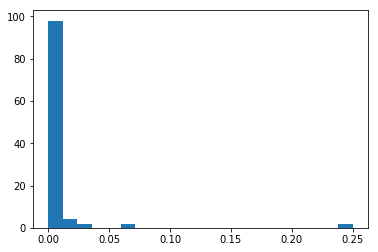

In [157]:
a =plt.hist(r,bins = len(r)/5)

In [159]:
len(r)

96

In [161]:
len(r)

104

In [170]:
c = 0
for k in r2:
    if np.var(k)>0:
        c= c+1
print c

18


In [164]:
len(r2)

108

In [171]:
r2

[[0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.18181818181818182, 0.0],
 [0.0, 0.0],
 [0.5, 0.5],
 [0.0, 0.0],
 [0.5, 0.5],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [1.0, 1.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.5],
 [0.5, 0.5639097744360902],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.36363636363636365, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 1.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.2, 0.5],
 [0.0, 0.0],
 [0.0, 1.0],
 [1.0, 0.5],
 [0.0, 0.0],
 [1.0, 1.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.14682539682539683],
 [0.0, 0.33],
 [0.0, 0.18181818181818182],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.3333333333333333, 0.5],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.18181818181818182, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.5, 0.2727272727272727],
 [0.0, 0.0],
 [0.0, 0.0],
 [0